# Оптимизация путей доставки

На Wildberries существует несколько видов доставки, которые отличаются местом отправления (склад WB или склад продавца), а также местом назначения (курьером на дом или в пункт выдачи заказов — далее ПВЗ).

**Задача:** показать наиболее оптимальный маршрут развоза товаров по ПВЗ со склада Wildberries в Коледино, при этом все машины должны быть загружены максимально, насколько это возможно, а стоимость перевозки линейно зависима от расстояния, которые проезжают машины. 

Предоставлены данные об адресах склада и ПВЗ, в которые необходимо доставить товары, а также о количестве товаров, которые нужно доставить в каждый ПВЗ, и о вместимости машин.

Конечным результатом должен стать алгоритм, позволяющий предоставить оптимальный маршрут развоза товаров со склада по ПВЗ такой, что затраты по времени в пути и стоимости перевозки будут минимальными.

Другими словами, если стоимость перевозки линейно зависит от расстояния и если мы считаем, что маршрут машины проедут с одинаковой скоростью, не попадут в пробку или иную непредвиденную ситуацию, то нужно найти такой маршрут, чтобы суммарная длина пути всех машин была минимальной, а их загрузка не превышала максимального допустимого значения.

Представим задачу в виде ориентированного взвешенного графа $D = (V,E)$:
- $V =$ {$v_{0}, v_{1}, ... v_{n}$} - множество вершин:
   - $v_{0}$ - склад;
   - $v_{1}, ... v_{n}$ - ПВЗ;
- $E$ - множество ребер (путей) {$(v_{i}, v_{j})|i≠j$};
- $C$ - матрица расстояний $c_{ij}$ между вершинами;
- $m$ - количество маршрутов/ машин;
- $R_{i}$ - маршрут i-й машины $(i = 1...m)$;
- $C(R_{i})$ - длина i-го маршрута;
- $q_{i}$ - количество товара, поставляемое в i-й ПВЗ $(i = 1...n)$;
- $Q$ - вместимость машины.

Тогда целевая функция примет вид:
$$\sum\limits_{i=1}^m C(R_{i})→min$$
при условии $\sum q_{i} <= Q$

**Цель работы:** разработать алгоритм, позволяющий предоставить оптимальный маршрут развоза товаров со склада по ПВЗ такой, что суммарная длина пути доставки всех машин будет минимальной, а их загрузка не превысит максимального допустимого значения.

**Ход работы:**
* первичный анализ данных и их очистка;
* исследование проблематики, выбор подходящих решений;
* формирование обучающей выборки, проектирование валидации;
* разработка бейзлайна и реализация выбранного решения;
* оценка решения, оптимизация алгоритма.

## Обзор даннных

In [1]:
#импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#чтение и сохранение данных, вывод первых 10 строк
data = pd.read_csv('./wb_school_task_3.csv.gzip', compression='gzip')
data.head(10)

,count,max,max.1,dst_office_id,office_name,latitude,longitude
0,379,2023-04-24,507,105643,МО Одинцово Садовая 24,55.676228,37.248839
1,249,2023-04-24,507,133447,МО Кашира Ленина 15,54.844701,38.191166
2,345,2023-04-24,507,110999,МО Одинцово Сколковская 1Б,55.694942,37.324654
3,591,2023-04-24,507,5807,Подольск Победы 12,55.360190,37.512755
4,322,2023-04-24,507,3300,МО Свердловский Строителей 22,55.903330,38.155216
5,930,2023-04-24,507,106294,МСК Генерала Белова 29,55.614762,37.721023
6,450,2023-04-24,507,112009,МСК Александры Монаховой 99,55.541027,37.491668
7,708,2023-04-24,507,5731,МСК Харьковская 2,55.587716,37.652759
8,52,2023-04-24,507,156980,МО Орехово-Зуево Карла Либкнехта 7,55.800630,38.975238
9,398,2023-04-24,507,108673,Балашиха Свердлова 16/5,55.821880,37.969703


In [3]:
#вывод информации о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   count          1800 non-null   int64  
 1   max            1800 non-null   object 
 2   max.1          1800 non-null   int64  
 3   dst_office_id  1800 non-null   int64  
 4   office_name    1800 non-null   object 
 5   latitude       1800 non-null   float64
 6   longitude      1800 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 98.6+ KB


Предоставленная таблица состоит из 7 столбцов:
* `count` - количество товаров, которое необходимо доставить в данный ПВЗ, тип данных - int;
* `max` - дата доставки (выгрузки данных), тип данных - object;
* `max.1` - максимальная загрузка машины, тип данных - int;
* `dst_office_id` - id ПВЗ, тип данных - int;
* `office_name` -  адрес ПВЗ, тип данных - object;
* `latitude` - широта, тип данных - float;
* `longitude` - долгота, тип данных - float.

В таблице 1800 записей, в каждом отдельном столбце также по 1800 записей, следовательно, пропуски отстутствуют. 

## Подготовка данных

### Проверка на наличие дубликатов

Проверим данные на наличие дубликатов.

In [4]:
#вывод количества дубликатов в таблице
data.duplicated().sum()

0

Дубликаты в таблице отсутствуют.

### Удаление неинформативных данных

Удалим из таблицы все признаки, которые не будут являться информативными при решении задачи - `max`, `dst_office_id` и `office_name`.

In [5]:
#удаление столбцов max, dst_office_id и office_name
data = data.drop(['max', 'dst_office_id', 'office_name'], axis=1)

### Переименование столбцов

Переименуем столбец со значением максимально возможной загрузки машины из `max.1` в `max`.

In [6]:
#переименование столбца max.1 в max
data = data.rename(columns={'max.1': 'max'})
data.head()

,count,max,latitude,longitude
0,379,507,55.676228,37.248839
1,249,507,54.844701,38.191166
2,345,507,55.694942,37.324654
3,591,507,55.360190,37.512755
4,322,507,55.903330,38.155216


## Исследовательский анализ данных

Посмотрим на описательную статистику данных.

In [7]:
data.describe()

,count,max,latitude,longitude
count,1800.000000,1800.0,1800.000000,1800.000000
mean,485.050000,507.0,55.726075,37.678796
std,242.537271,0.0,0.271906,0.447394
min,3.000000,507.0,54.463403,35.507735
25%,309.000000,507.0,55.624623,37.468130
50%,455.500000,507.0,55.744627,37.614515
75%,626.000000,507.0,55.864669,37.854267
max,1981.000000,507.0,56.762163,39.876429


Можно заметить, что значения максимальной загрузки машин не меняется для всех ПВЗ, а также что значения широты и долготы не сильно разбросаны и выглядят вполне правдоподобно. Значения столбца с количеством товара для ПВЗ нужно проверить на наличие выбросов. 

Посмотрим, как распределены значения в столбце `count`.

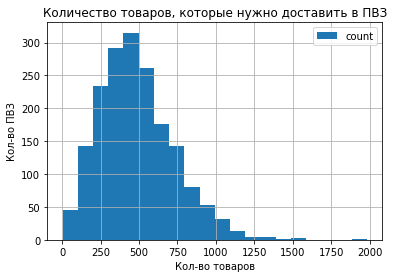

In [8]:
#строим гистограмму для столбца count
ax = data.plot(kind='hist', 
               y='count',
               bins=20, 
               title='Количество товаров, которые нужно доставить в ПВЗ',
               grid=True)
ax.set(xlabel='Кол-во товаров', ylabel='Кол-во ПВЗ');

Значения распределены нормально, можно заметить, что присутствуют несколько аномальных значений. Проверим столбец `count` на наличие выбросов, построим диаграмму размаха.

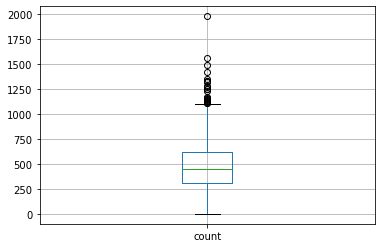

In [9]:
#строим диаграмму размаха для столбца count
data.boxplot('count');

По диаграмме размаха также можно заметить некоторое количество выбросов, самое большое значение из них - около 2000, при этом медианное значение около 450. Эти значения вряд ли стоит удалять, потому что они не похожи на результат ошибки при вводе данных, и потому что они не должны существенно повлиять на решение задачи (в какой-то ПВЗ машина заедет на один-два раза больше, чем в другие).